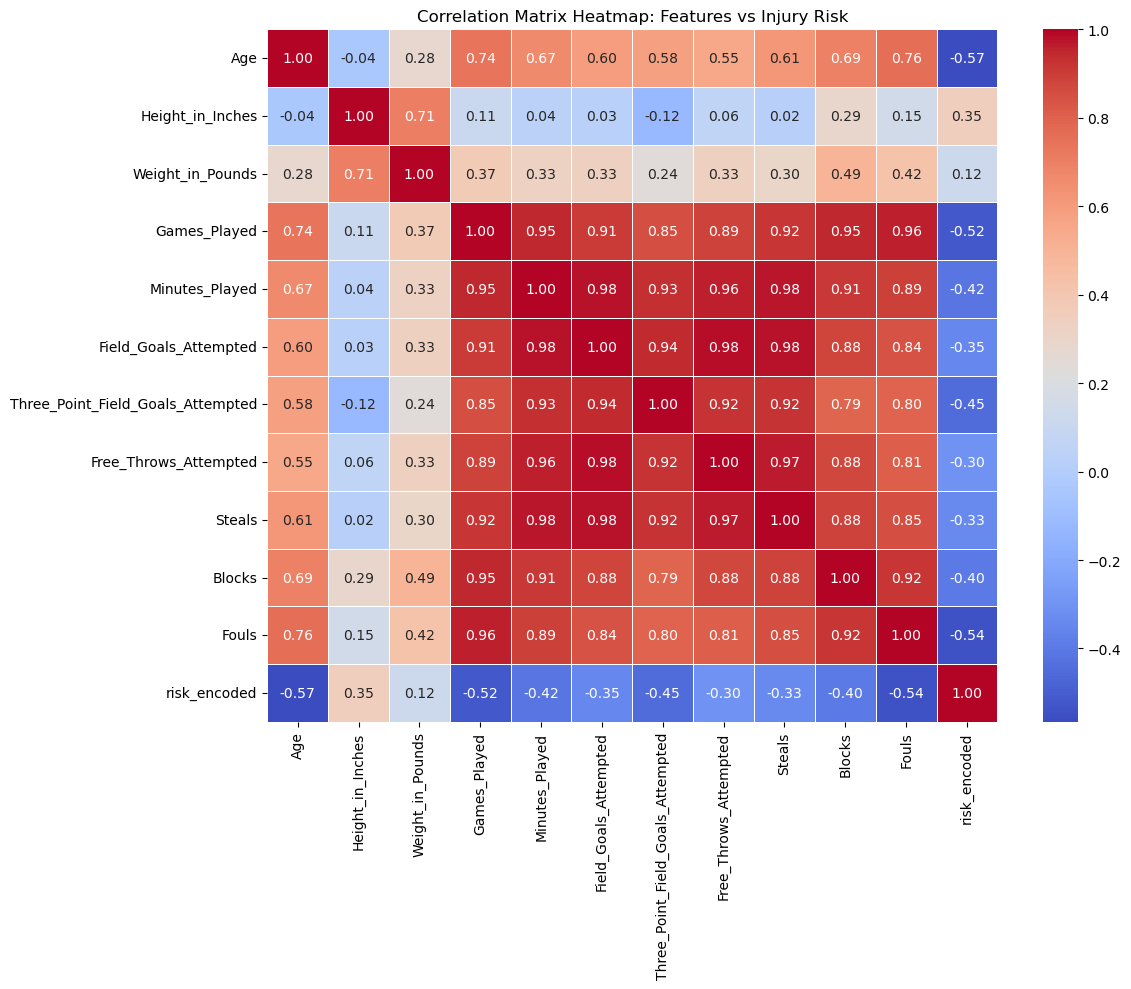

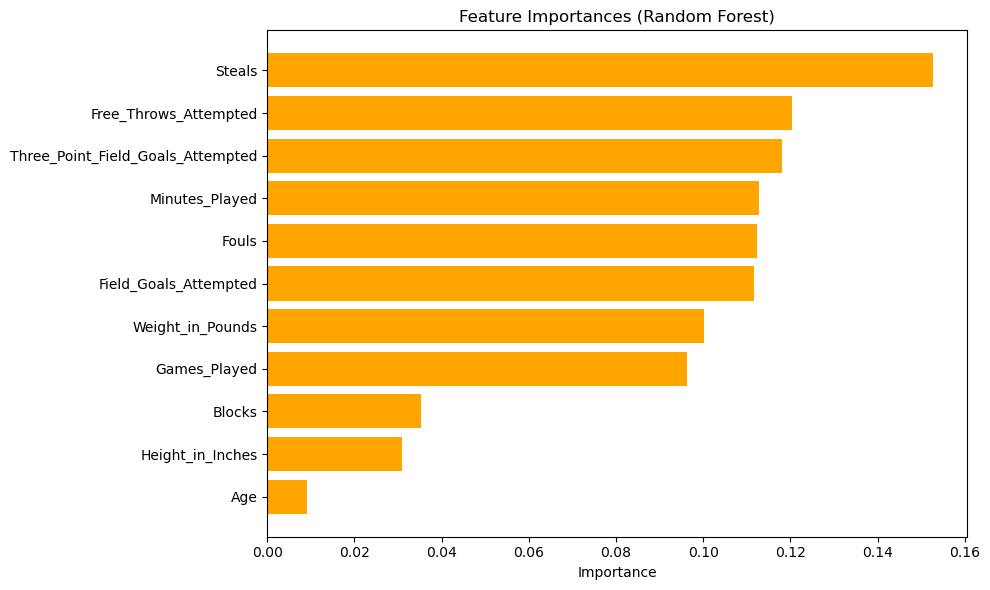

In [33]:
# 1. Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 2. Load the dataset
df = pd.read_csv("player_data.csv")

# 3. Compute performance load
df["performance_load"] = (
    df["Games_Played"] * df["Minutes_Played"]
    + df["Field_Goals_Attempted"]
    + df["Three_Point_Field_Goals_Attempted"]
    + df["Free_Throws_Attempted"]
)

# 4. Heuristic label assignment
def assign_risk_label(row):
    injuries = row["Total_Injuries"]
    perf_load = row["performance_load"]
    injury_type = str(row["Most_Common_Injury"]).lower()
    if injuries <= 2 and injury_type in ["eye", "illness", "none"]:
        return "Low"
    elif 3 <= injuries <= 5 and perf_load < 10000:
        return "Low-Medium"
    elif 3 <= injuries <= 5 and perf_load >= 10000:
        return "Medium"
    elif 6 <= injuries <= 10 and perf_load >= 15000:
        return "Medium-High"
    elif injuries > 10 and perf_load >= 20000:
        return "High"

df["predicted_risk_label"] = df.apply(assign_risk_label, axis=1)

# 5. Encode target labels
label_encoder = LabelEncoder()
df["risk_encoded"] = label_encoder.fit_transform(df["predicted_risk_label"])

# 6. Define features
features = [
    "Age", "Height_in_Inches", "Weight_in_Pounds",
    "Games_Played", "Minutes_Played",
    "Field_Goals_Attempted", "Three_Point_Field_Goals_Attempted",
    "Free_Throws_Attempted", "Steals", "Blocks", "Fouls"
]

X = df[features]
y = df["risk_encoded"]

# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 9. Correlation Matrix Heatmap
df_corr = df[features + ["risk_encoded"]]
corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap: Features vs Injury Risk")
plt.tight_layout()
plt.show()

# 10. Feature Importances Bar Chart
importances = model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx], color="orange")
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
